In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.signal import cheby1
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import math
from math import sin, cos, pi, sqrt,tan, atan
from pytexit import py2tex
import skrf as rf
from skrf.media import MLine
import subprocess
import os
import sys

def mW_to_dBm(milliwatts):
    return 10.0*math.log10(milliwatts)

# Stepped-impedance filter sim, method 1

[Kapilevich 1999], a cleaner version of which is at [Kapilevich 1998]


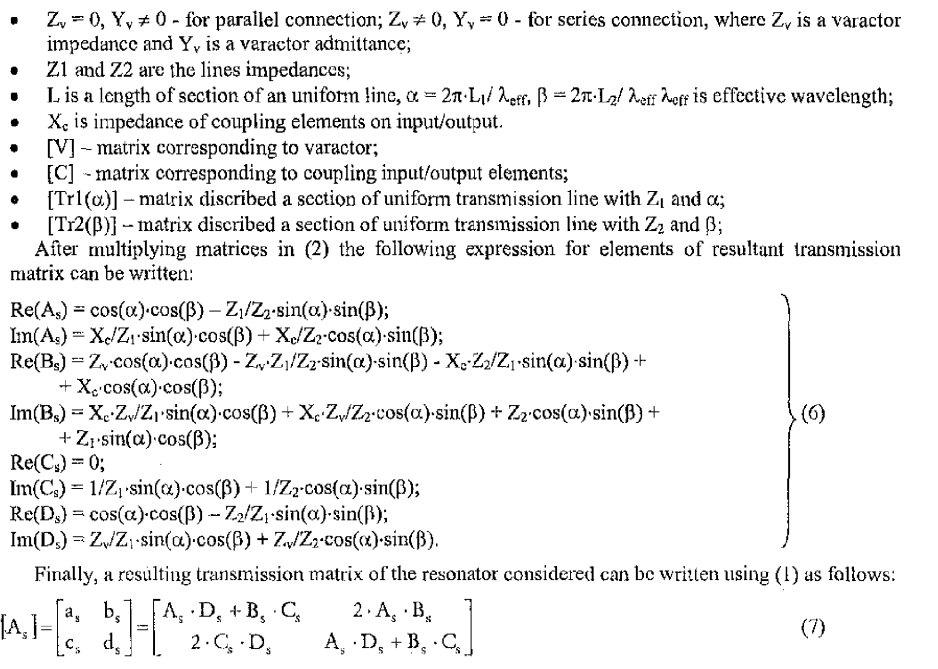



In [69]:
def effective_wavelength(trace_width, substrate_height, dielectric_constant, frequency):
    '''
    m, m, --, Hz. Returns wavelength in meters.
    thanks https://www.pasternack.jp/t-calculator-phase-length.aspx !
    :
    >>> round(effective_wavelength(0.5, 10, 4.4, 6e9), 4)
    0.0296
    >>> round(effective_wavelength(10, 0.5, 4.4, 6e9), 4)
    0.0249
    '''
    if(trace_width / substrate_height < 1):
        effective_permittivity = ((dielectric_constant + 1.0)/2.0) + \
                        (((dielectric_constant - 1.0)/2.0) * \
                         ((1.0/math.sqrt(1.0+(12.0*(substrate_height/trace_width))))) + \
                         0.04*((1.0-(trace_width/substrate_height))**2.0))
    if(trace_width / substrate_height >= 1):
        effective_permittivity = ((dielectric_constant + 1.0)/2.0) + \
                        (((dielectric_constant - 1.0)/(2.0*math.sqrt(1.0+12.0*(substrate_height/trace_width)))))

    lambda_eff_m = 3.0e8 / (frequency * math.sqrt(effective_permittivity))
    return lambda_eff_m

def microstrip_width(impedance, substrate_height, trace_height, dielectric_constant):
    '''
    >>> round(microstrip_width(50.0, 0.79, 0.032, 4.4), 4)
    1.4388
    '''
    return (7.48*substrate_height/math.pow(math.e, impedance * (math.sqrt(dielectric_constant+1.41)/87.0))) \
                - 1.25*trace_height



2071000000.0


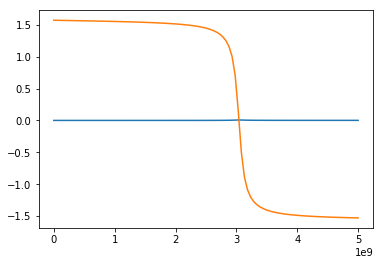

In [389]:
max_impedance = 114.2 #from wCalc - microstrip_width() could be inverted, of course
min_impedance = 25.0 

center_frequency = 3e9 # Hz

#-------------------------------------------------
substrate_height = 2e-3  #m
substrate_dielectric_constant = 2.6
copper_thickness = 32e-6 #m
#-------------------------------------------------
varactor_resistance = 1.4 #Ohms
varactor_inductance = 0.7e-9 #Henries
#-------------------------------------------------
coupling_inductance = 0.2e-9 #Henries
#-------------------------------------------------
system_impedance = 50

#     #-------------------------------------------------
#     physical_line_width_1 = microstrip_width(Z1, substrate_height, copper_thickness, substrate_dielectric_constant) #m
#     effective_wavelength_1 = effective_wavelength(physical_line_width_1,substrate_height,
#                                             substrate_dielectric_constant, center_frequency)
#     alpha = 2.0*math.pi*physical_line_length_1/effective_wavelength_1
#     #-------------------------------------------------
#     physical_line_width_2 = microstrip_width(Z2, substrate_height, copper_thickness, substrate_dielectric_constant) #m
#     effective_wavelength_2 = effective_wavelength(physical_line_width_2,substrate_height,
#                                             substrate_dielectric_constant, center_frequency)
#     beta = 2.0*math.pi*physical_line_length_2/effective_wavelength_2
#     #-------------------------------------------------

def compute_varactor_filter_S21(Z1, Z2, alpha, beta, varactor_capacitance, \
                                            coupling_capacitance, frequency):
    '''
    Ohms impedance, Ohms impedance, meters, meters, Farads, Farads, Hz
    '''

    X_c = complex(0.0, -1.0/(2.0*math.pi*frequency*coupling_capacitance))
    #-------------------------------------------------


    varactor_total_reactance = (2.0*pi*frequency*varactor_inductance) + \
                                (-1.0/(2.0*pi*frequency*varactor_capacitance))
    varactor_impedance = complex(varactor_resistance, varactor_total_reactance)
    #-------------------------------------------------


    A_s_real = cos(alpha)*cos(beta)-Z1/Z2*sin(alpha)*sin(beta)
    A_s_imaginary = X_c/Z1*sin(alpha)*cos(beta) + X_c/Z2*cos(alpha)*sin(beta)

    B_s_real = varactor_impedance*cos(alpha)*cos(beta) - varactor_impedance*Z1/Z2*sin(alpha)*sin(beta)+\
                        X_c*cos(alpha)*cos(beta)
    B_s_imaginary = X_c*varactor_impedance/Z1*sin(alpha) * cos(beta) + X_c*varactor_impedance/Z2*cos(alpha)*sin(beta)+ \
                    Z2*cos(alpha)*sin(beta)+Z1*sin(alpha)*cos(beta)
    
    C_s_real = 0
    C_s_imaginary = 1.0/Z1*sin(alpha)*cos(beta) + 1.0/Z2*cos(alpha)*sin(beta)

    D_s_real = cos(alpha)*cos(beta) - Z2/Z1*sin(alpha)*sin(beta)
    D_s_imaginary = varactor_impedance/Z1 * sin(alpha) *cos(beta) + varactor_impedance/Z2*cos(alpha)*sin(beta)

    A_s = complex(A_s_real,A_s_imaginary)
    B_s = complex(B_s_real,B_s_imaginary)
    C_s = complex(C_s_real,C_s_imaginary)
    D_s = complex(D_s_real,D_s_imaginary)
    
    #note that this is a transmission matrix, rather than a scattering matrix.
    a_s = A_s*D_s+B_s*C_s
    b_s = 2.0*A_s*B_s
    c_s = 2.0*C_s*D_s
    d_s = A_s*D_s+B_s*C_s
    
    #S_21 = 1.0/d_s #[Pierre 2016]
    
    S_21 = (2.0*sqrt(Z1*Z2))/(a_s*Z1+d_s*Z2+b_s*Z1*Z2+c_s) #(eq 14) Kap. 1999
    
    
    S_11 = A_s*B_s - (system_impedance**2.0)*C_s*D_s
    
    return S_21, S_11

frequencies = []
magnitude = []
phases = []
S_11s = []
for f in np.linspace(0.500e6, 5000e6, num=100):
    S_21, S_11 = compute_varactor_filter_S21(25, 85, 1.44, 0.87, 2e-12, 0.85e-12, f)
    S_21_magnitude = abs(S_21)
    S_11s.append(abs(S_11))
    magnitude.append(S_21_magnitude)
    frequencies.append(f)
    phases.append(math.atan(S_21.imag/S_21.real))

print(frequencies[S_11s.index(min(S_11s))])

plt.plot(frequencies,magnitude)
plt.plot(frequencies,phases)
plt.show()
#minimize(bounds=[(20e-3, 100e-3)])


# Stepped-impedance filter sim, method 2

Series, capacitor-coupled

[Kapilevich 1999], [Kapilevich 1998], [Kapilevich 2007]

Many equations have been distorted by typesetting.

The coupling element table is at [2007].

"Plots marked with circles are the
first resonance, squares are the second resonance."

Hang on, [2007] isn't talking about stepped-impedance filters, only single-impedance regular ones.

In [388]:

frequency = 2e9
coupling_capacitance = 1e-12
coupling_reactance = -1.0/(2.0*pi*frequency*coupling_capacitance)

def total_resonator_electrical_length(coupling_reactance, varactor_impedance, system_impedance):
    
    '''
    >>> round(total_resonator_electrical_length(-300,55,50),3)
    2.95
    '''
    
    #Filter:
    #       | ------------phi------------|
    # [X_c] [Z0 alpha long] [Z1 beta long] | [mirror]

    
    #varactor impedance might be the normalized version? Z_v/Z0? we'll see

    # there're two names for the same system_impedance.
    a = -16.0 * coupling_reactance + 4.0 * varactor_impedance * (coupling_reactance**2.0)/(system_impedance**2.0) \
                    - 4.0 * varactor_impedance + 4.0 * varactor_impedance*(system_impedance**2.0)/(system_impedance**2.0)

    b = -2.0 * coupling_reactance - varactor_impedance

    d = (coupling_reactance**2.0)/system_impedance + varactor_impedance*coupling_reactance/system_impedance \
                    - system_impedance + (system_impedance**2.0)/system_impedance

    P_1 = a**2.0 + 64.0*(d**2.0)
    P_2 = 2.0*(a**2.0) + 128.0*(d**2.0)
    P_3 = a**2.0 + 2.0*a*b + 80.0*(d**2.0)
    P_4 = 2.0*a*b + 16.0*(d**2.0)
    P_5 = (b**2.0)

    # Equation: P_5 + P_4 t + P_3 t^2 + P_2 t^3 + P_1 t^4 = 0
    # t = cos^2((alpha+beta)/2)
    # where alpha+beta is the electrical length of one resonator
    p = np.polynomial.Polynomial([P_5,P_4,P_3,P_2,P_1])
    T = abs(p.roots()[0])
    n=0
    phi = abs(4.0*pi*n-2.0*(1.0/cos(-sqrt(T))))
    
    return phi
    
#phi = total_resonator_electrical_length(,55)
print(total_resonator_electrical_length(6,2,1))
print(total_resonator_electrical_length(6,1.2,1))


3.682944609049425
3.6830084263249496


# Stepped-impedance filter sim, method 3

[Lee 2008]

Using the coupling matrix in (3) and (4)–(7), we can compute
the required C’s and $\phi$’s and they are summarized in Table III

> The slope parameter dB was extracted from a simulation.

[Levy 2002] has some slope parameters.

I knew care in typesetting made things more pleasant to read, but I never realized how incomprehensible poorly-set math is

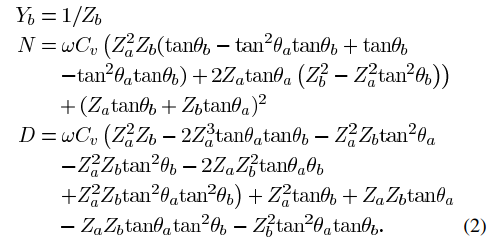

In [194]:

def compute_coupled_varactor_filter_S21(Z1, Z2, ):
    t = 1 + q

#passband_ripple = # dB
#scipy.signal.cheby1(2, ,btype='low')
chebyshev_M_01 = 1.225
chebyshev_M_12 = 1.660
chebyshev_M_23 = 1.225

def Y_in(Z_a, Z_b, theta_a, theta_b,angular_frequency,varactor_capacitance):
    Y_b = 1.0/Z_b
    N = (angular_frequency*varactor_capacitance)*((Z_a**2.0)*Z_b*(tan(theta_b)-((tan(theta_a)**2.0)*tan(theta_b)) \
                                            +tan(theta_b)-((tan(theta_a)**2.0)*tan(theta_b))) \
                                            +((2.0*Z_a*tan(theta_a)*(Z_b**2.0-((Z_a**2.0)*(tan(theta_b)**2.0)))))) \
                                            +((Z_a*tan(theta_b)+Z_b*tan(theta_a))**2.0)
                                  
    D = (angular_frequency*varactor_capacitance)*((Z_a**2.0)*Z_b-2.0*(Z_a**3.0)*tan(theta_a)*tan(theta_b)- \
                                                  (Z_a**2.0)*Z_b*(tan(theta_a)**2.0)-(Z_a**2.0)*Z_b*(tan(theta_b)**2.0)-\
                                                  2.0*Z_a*(Z_b**2.0)*tan(theta_a)*theta_b - \
                                                  ## is this really tan(theta_a)*theta_b?
                                                  +(Z_a**2.0)*Z_b*(tan(theta_a)**2.0)*(tan(theta_b)**2.0)) + \
                                                  (Z_a**2.0)*tan(theta_b) + Z_a*Z_b*tan(theta_a) - \
                                - Z_a*Z_b*tan(theta_a)*tan(theta_b)**2.0 - (Z_b**2.0)*(tan(theta_a)**2.0)*tan(theta_b)
    return Y_b * (N/D)


print(Y_in(85,25,pi,pi,2.0*pi*6e9,1e-12))
#scipy.optimize.approx_fprime(x, func, epsilon)

#hang on a minute. 
#For resonant frequency and slope parameter calculation, input admittance of the resonator should be derived.
# But you can't do that until you know the thetas!
# they used a simulation to determine theadalkdjfa;lkdjf a;lkdjf a;lkdjfa 'l;dfj adaaaaaaaaaaaaa'

#py2tex('D =')

-1.2678696273525537e-17


# Stepped-impedance filter sim, scaled reference design



In [71]:
substrate_height = 0.79e-3  #m
substrate_dielectric_constant = 4.4

reference_center_frequency = 1263e6 + ((2000-1263)*0.5e6)

desired_center_frequency = 8000e6

scale_factor = desired_center_frequency/reference_center_frequency

coupling_capacitance = 0.84e-12
alpha = 0.144 #rad
beta = 0.87 #rad

coupling_capacitance /= scale_factor

#alpha /= scale_factor - too small to manufacture
#beta /= scale_factor -

W_1 = 4.139e-3 #25 ohms
W_2 = 0.501e-3 #85 ohms

lambda_0 = effective_wavelength(W_1, substrate_height, substrate_dielectric_constant, desired_center_frequency)
lambda_1 = effective_wavelength(W_2, substrate_height, substrate_dielectric_constant, desired_center_frequency)

len_1 = lambda_0 * (alpha/(2.0*pi))
len_2 = lambda_1 * (beta/(2.0*pi))

print(scale_factor)
print("Alpha: {} | Beta: {} | C: {}".format(alpha, beta, coupling_capacitance/1e-12))
print("len_1: {} | len_2: {}".format(len_1/1e-3, len_2/1e-3))

#also try shunt varactor! inductance may have a different effect



4.903463070793748
Alpha: 0.144 | Beta: 0.87 | C: 0.1713075
len_1: 0.4506416867808939 | len_2: 2.9556754906659983


# Stepped-impedance filter optimization, QUCS

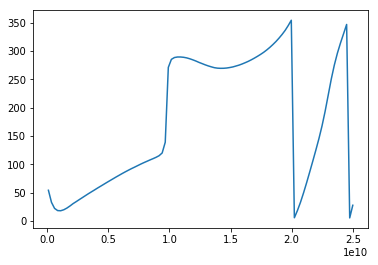

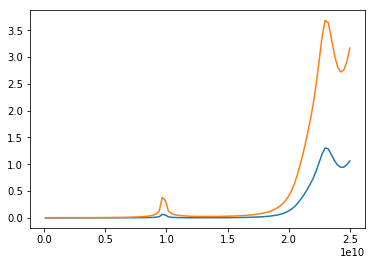

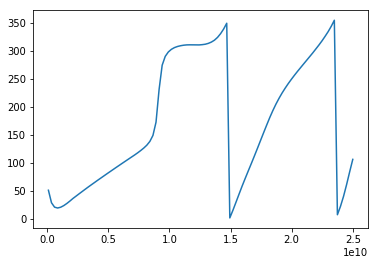

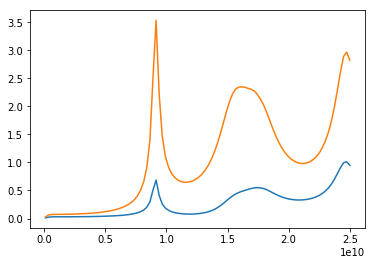

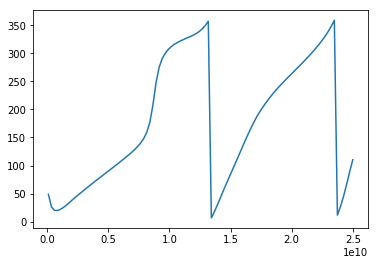

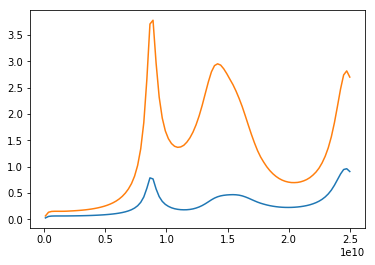

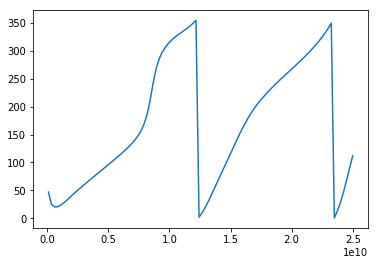

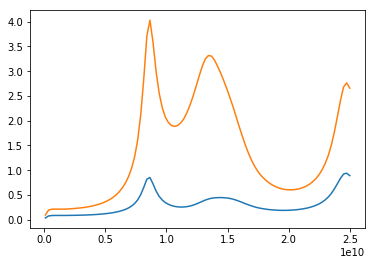

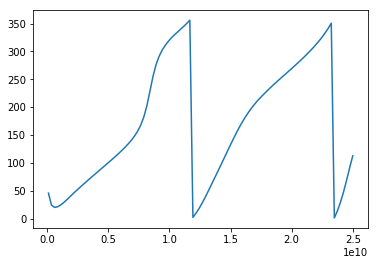

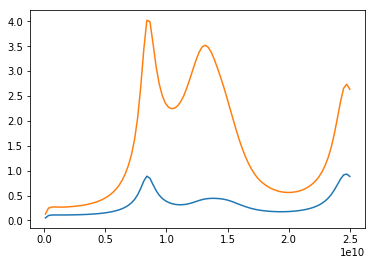

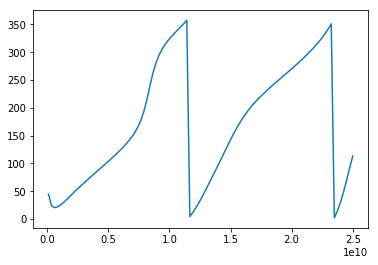

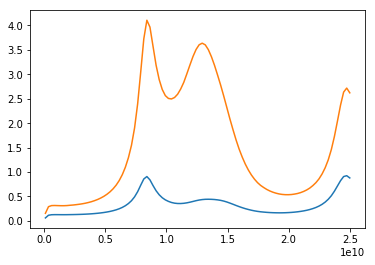

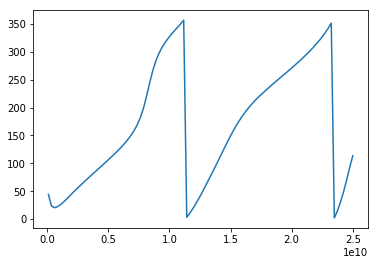

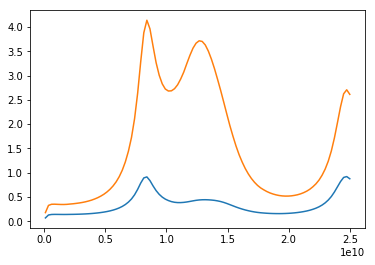

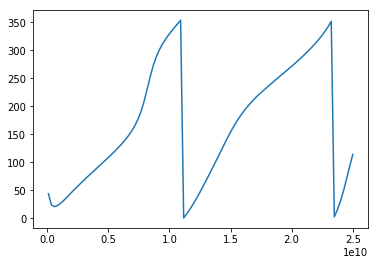

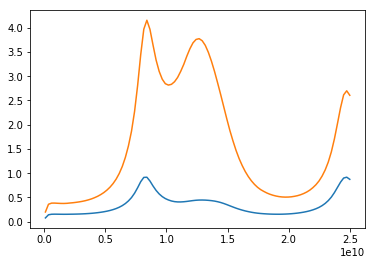

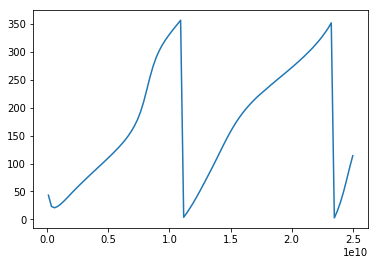

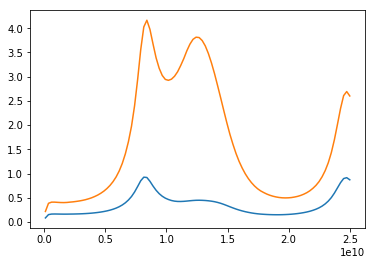

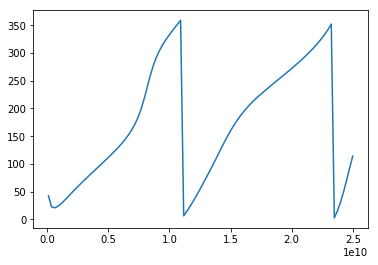

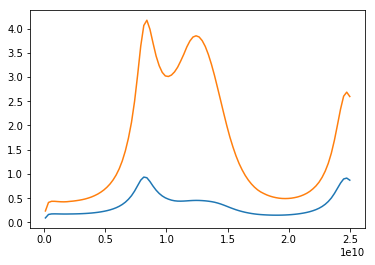

In [55]:
import qucs.extract
from time import sleep

Z1 = 25
Z2 = 85

width_1 = 4.139e-3 #25 ohms: "alpha", lowZ
width_2 = 0.501e-3 #85 ohms: "beta", highZ


schematic_file = "/home/arthurdent/Projects/covidinator/electronics/qucs/optimize/optimize_filter_1.sch"
net_file = "/home/arthurdent/Projects/covidinator/electronics/qucs/optimize/optimize_filter_1.net"
net_file_modified = "/home/arthurdent/Projects/covidinator/electronics/qucs/optimize/optimize_filter_1_mod.net"
data_file = "/home/arthurdent/Projects/covidinator/electronics/qucs/optimize/optimize_filter_1.dat"

os.system("QUCSDIR=/usr/local/ /usr/local/bin/qucs -n -i " + schematic_file + " -o " + net_file)


def electrical_to_physical_length(electrical_len, trace_width, frequency):
    return (effective_wavelength(trace_width, substrate_height, substrate_dielectric_constant, frequency) \
                            * (electrical_len/(2.0*pi)))


def run_sim(x, C_varactor, net_file, data_file):
    
#     electrical_length_ratio = 0.625
    
#     electrical_length_beta = - (electrical_length_alpha*electrical_length_ratio/(electrical_length_ratio-1.0))
    
#     length_1 = electrical_to_physical_length(electrical_length_alpha, width_1, center_frequency)
#     length_2 = electrical_to_physical_length(electrical_length_beta, width_2, center_frequency)
    
#     print("Trying lengths: {:.4f} rad ({:.4f} m) | {:.4f} rad ({:.4f} m) ".format(electrical_length_alpha, length_1, beta, length_2))
    
    length_1 = x[0]
    length_2 = x[1]
    length_3 = x[2]
    C_1 = x[3]
    
    with open(net_file, 'r') as file:
      netlist = file.read()

    netlist = netlist.replace('length_1', str(length_1) + " mm")
    netlist = netlist.replace('length_2', str(length_2) + " mm")
    netlist = netlist.replace('length_3', str(length_3) + " mm")

    netlist = netlist.replace('C_1', str(C_1) + " pF")
    netlist = netlist.replace('C_varactor', str(C_varactor) + " pF")
    
    with open(net_file_modified, 'w') as file:
        file.write(netlist)
    
    sim_return = subprocess.run(['qucsator', '-i', net_file_modified, '-o', data_file], check=True)
    
    extracted_data = qucs.extract.load_data(data_file)
    
    return extracted_data.__dict__["acfrequency"], extracted_data.__dict__["Vfb_v"], extracted_data.__dict__["phase_shift"],\
                             extracted_data.__dict__["Vamp2_v"]


varactor_start = 0.3 #pF
varactor_end = 5.0 # pf

def freq_sweep(x):
    peak_gains = []
    peak_freqs = []
    peak_phases = []

    for varactor_capacitance in np.linspace(varactor_start,varactor_end,num=5):

        freq, Vfb, phases, Vamp2 = run_sim(x, varactor_capacitance, net_file, data_file)

        Vfb_magnitude = [abs(i) for i in Vfb]

        peak_indice = find_peaks(Vfb_magnitude, height = 0.1)[0][0]
        peak_gains.append(Vfb_magnitude[peak_indice]) 
        peak_freqs.append(freq[peak_indice])
        peak_phases.append(phases[peak_indice])

    return peak_freqs, peak_phases, peak_gains




def cost_function(x):
 
    peak_freqs, peak_phases, peak_gains = freq_sweep(x)
    
    min_phase = min(peak_phases)
    min_gains = min(peak_gains)
    span = (max(peak_freqs) - min(peak_freqs))
    
    center_freq = ((max(peak_freqs) - min(peak_freqs))/2.0) + min(peak_freqs)
    
    Coeff1 = 1.0/360.0
    Coeff2 = 1.0/4e9
    Coeff3 = 1.0/8e9
    Coeff4 = 1.0

    print(min_phase)
#     print(min_gains)
#     print(span)
    sleep(0.1)
    cost = (Coeff1 * (360.0 - min_phase))
#     cost = (Coeff1 * (360.0 - min_phase)) + (Coeff2 * abs((4e9 - span))) +  \
#                 (Coeff3 * abs((8e9 - center_freq))) + (Coeff4 * abs((1.0 - min_gains)))
    print(cost)
    return cost

for i in np.linspace(0.05, 2, 10):
#     peak_freqs, peak_phases, peak_gains = freq_sweep([2.955, 0.45, 0.01, i])
#     print(min(peak_phases))

    const = 1.0
    freq, Vfb, phases, Vamp2 = run_sim([2.955*const, 0.45*const, 0.01, i], 0.3, net_file, data_file)
    
    plt.figure()
    plt.plot(freq, phases)
    Vfb_magnitude = [abs(i) for i in Vfb]
    Vamp2_magnitude = [abs(i) for i in Vamp2]
    plt.figure()
    plt.plot(freq, Vfb_magnitude)
    plt.plot(freq, Vamp2_magnitude)

#     peak_freqs, peak_phases, peak_gains = freq_sweep([2.955*const, 0.45*const, 0.01, i])
#     plt.figure()
#     plt.plot(peak_phases)
    #plt.plot(peak_freqs)
#minimize(cost_function, [2.955, 0.45, 0.17], bounds=[(0.5,5),(0.5,5.0),(0.1,10)], options={"disp":True})

#minimize(cost_function, [2.955, 0.45, 1, 0.17], bounds=[(0.5,5),(0.5,5.0),(0.1,10)], options={"disp":True})

# Stepped-impedance filter sim, Scikit-rf

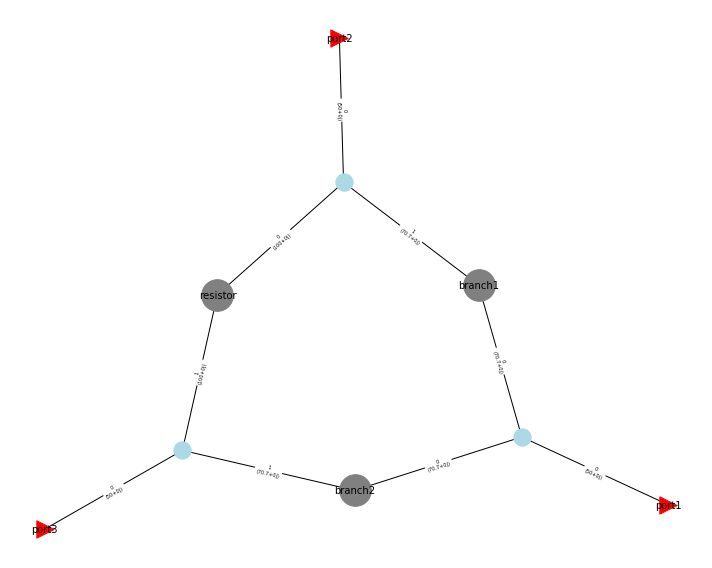

In [158]:
freq = rf.Frequency(start=0, stop=10, npoints=501, unit='GHz')

# characteristic impedance of the ports
Z0_ports = 50

# resistor
R = 100
line_resistor = rf.media.DefinedGammaZ0(frequency=freq, Z0=R)
resistor = line_resistor.resistor(R, name='resistor')

# branches
Z0_branches = np.sqrt(2)*Z0_ports
beta = freq.w/rf.c
line_branches = rf.media.DefinedGammaZ0(frequency=freq, Z0=Z0_branches, gamma=0+beta*1j)

d = line_branches.theta_2_d(90, deg=True)  # @ 90°(lambda/4)@ 1 GHz is ~ 75 mm
branch1 = line_branches.line(d, unit='m', name='branch1')
branch2 = line_branches.line(d, unit='m', name='branch2')

# ports
port1 = rf.Circuit.Port(freq, name='port1', z0=50)
port2 = rf.Circuit.Port(freq, name='port2', z0=50)
port3 = rf.Circuit.Port(freq, name='port3', z0=50)

# Connection setup
#┬Note that the order of appearance of the port in the setup is important
connections = [
           [(port1, 0), (branch1, 0), (branch2, 0)],
           [(port2, 0), (branch1, 1), (resistor, 0)],
           [(port3, 0), (branch2, 1), (resistor, 1)]
        ]

# Building the circuit
C = rf.Circuit(connections)


C.plot_graph(network_shape='o',network_labels=True, edge_labels=True, port_labels=True, network_size=1000, \
                 network_fontsize=10, edges_fontsize=10, port_fontsize=10)


# Amplifier phase shift

this shift will have to be compensated for by a phase-shifter network, I think

# Stepped-impedance filter sim, method 4

[Weiping 2012]

> When two resonators with the same resonance frequency are coupled together, their
resonance frequency will separate, as shown in Fig. 3.
f1 and f2 are introduced to represent the two separate resonate frequencies , the
coupling coefficient can be defined as: 

AWESOME



In [215]:
max_impedance = 80
min_impedance = 25

R_z = min_impedance/max_impedance

theta_1 = 1

theta_total = atan(R_z/tan(theta_1))

theta_2 = theta_total-theta_1

theta_2

-0.8019757284529481

# Combline filter sim via Hunter 1982

[Hunter 1982]

> Thus, in summary, we initially obtain the element values
CL. and $K_{r,r+1}$ for the low-pass prototype filter, normally
the Chebyshev prototype [6].
Next, $\phi_0$ must be chosen noting that for optimum return
loss $\phi_0$ should be 45° and for minimizing the bandwidth
variation with tuned frequency $\phi_0$ should be 52.8850°

>Next, the value of the lumped tuning capacitors at mid-tuning
band should be chosen and then applying (30) to (33) for
r = 1 to n the element values Yr and Yr,r+1 can be obtained.

> Finally the admittances of the input and output coupling
Y. Y,’ elements are obtained from (27)–(29).

In [219]:

#scipy.signal.cheby1(,btype='low')




SyntaxError: invalid syntax (<ipython-input-219-939505aa28ed>, line 1)

# Combline filter sim via Hunter 2001

Chapter 5.6.1 Design Example

First we obtain the filter coefficients and denormalize to 50R.

This is quite similar to the filter used in [], but without the phasing network. We'll probably need that later.

Frequency scaling: 

`L' = L/kf`
`C' = C/kf`

Impedance scaling: 

`L' = kz * L`

`C' = C / kz`

Degree 2 combline  - however, only degree 3 has favorable phase response

In [380]:
#%%python3 
#isolate this cell from other variables
from math import sin, cos, pi, sqrt,tan, atan, pow, e, sinh, asinh
from scipy.signal import cheby1
import skrf as rf

# m = MLine(frequency=freq, z0=50, w=W, h=H, t=T,
#     ep_r=ep_r, mu_r=1, rho=1.712e-8, tand=tand, rough=0.15e-6,
#     f_low=1e3, f_high=1e12, f_epr_tand=f_epr_tand,
#     diel='djordjevicsvensson', disp='kirschningjansen')

#cheby1(N=2,rp=20,Wn=1,btype='low',analog=True)

center_frequency = 10000e6
bandwidth = 100e6
system_impedance = 50.0

reference_frequency = 1.0 # defined by the Cheby. filter table
reference_impedance = 1.0 # defined by the Cheby. filter table

freq_scaling = (2.0*pi*center_frequency)/reference_frequency
impedance_scaling = system_impedance/reference_impedance

C_1 = 1.4029 # from Cheb. table, http://www.rfcafe.com/references/electrical/cheby-proto-values.htm

N = 2 #order! order!

insertion_loss = 20.0 #dB
epsilon = abs(sqrt(pow(e, insertion_loss/10.0)-1.0))
nu =  sinh((1.0/N)*asinh(1.0/epsilon))# Eq. (3.75)
#insertion_loss = 10.0*log(1.0 + (epsilon**2.0))
K_12 = (((nu**2.0)+(3.0/4.0))**(0.5))/nu # Eq. (3.95)
K_23 = (((nu**2.0)+(3.0/4.0))**(0.5))/nu # Eq. (3.98)


theta_0 = 50.0 # chosen based on desired characteristics:
#for optimum return loss  𝜙0  should be 45°
#for minimizing the bandwidth variation with tuned frequency  𝜙0  should be 52.8850°
theta_0 = 2.0*pi*(theta_0/360.0) # deg to rad

angular_center_frequency = 2.0*pi*center_frequency
angular_bandwidth = 2.0*pi*bandwidth

alpha = 2.0*angular_center_frequency*tan(theta_0)/(angular_bandwidth*(tan(theta_0)+theta_0*(1.0+(tan(theta_0)**2.0))))
beta = 1.0 / ((angular_center_frequency)*tan(theta_0))
C = beta


Y_rr = C*(angular_center_frequency)*tan(theta_0)
n_1 = ((alpha*C_1*tan(theta_0))/Y_rr)**(0.5)
n_2 = n_1 # ??

Y_12 = (K_12 * tan(theta_0)) / (n_1*n_2)
Y_23 = (K_23 * tan(theta_0)) / (n_2**2.0)

Y_0 = 1.0 - (1.0/(n_1*cos(theta_0)))
Y_1 = 1.0 - Y_12 + 1.0/(n_1**2.0) - (1.0/(n_1*cos(theta_0)))

Y_01 = 1.0/(n_1*cos(theta_0))

Z_0 = 1.0/Y_0
Z_1 = 1.0/Y_1
Z_01 = 1.0/Y_01

Z_0 *= impedance_scaling #denormalize back to 50 ohms
Z_1 *= impedance_scaling
Z_01 *= impedance_scaling

C /= impedance_scaling

#-------------------------------------------------
substrate_height = 0.79e-3  #m
substrate_dielectric_constant = 4.4
copper_thickness = 32e-6 #m
#-------------------------------------------------

W_0 = microstrip_width(Z_0, substrate_height, copper_thickness, substrate_dielectric_constant)
W_1 = microstrip_width(Z_1, substrate_height, copper_thickness, substrate_dielectric_constant)

lambda_0 = effective_wavelength(W_0, substrate_height, substrate_dielectric_constant, center_frequency)
lambda_1 = effective_wavelength(W_1, substrate_height, substrate_dielectric_constant, center_frequency)

length_0 = (theta_0/(2.0*pi)) * lambda_0
length_1 = (theta_0/(2.0*pi)) * lambda_1


print("Z0: {:.4f} | Z1: {:.4f} | Z_01: {:.4f} | theta: {:.4f} rad".format(Z_0, Z_1, Z_01, theta_0))
print("0: {:.4f} l x {:.4f} w mm | 1: {:.4f} l x {:.4f} w mm".format(length_0/1e-3, W_0/1e-3, length_1/1e-3, W_1/1e-3))

series_shifting_capacitor = 0.5e-12
Cshifted = C*series_shifting_capacitor/(series_shifting_capacitor-C)

print("C: {:.3f} pF | Cshifted: {:.3f} pF".format(C/(1e-12), Cshifted/1e-12))



Z0: 58.2515 | Z1: 60.8659 | Z_01: 352.9739 | theta: 0.8727 rad
0: 2.3090 l x 1.1366 w mm | 1: 2.3156 l x 1.0544 w mm
C: 0.267 pF | Cshifted: 0.573 pF


# Point-blank power density

To 

In [44]:
frequency = 7e9

safe_power_density = 10.0      # W/m^2

safe_power_density *= 0.0001 # W/cm^2
safe_power_density /= 1000.0 # mW/cm^2


#antenna_area = safe_power_density / 

In [50]:
# it will be nigh-impossible to focus to less than a wavelength!

inactivation_power_density = 100.0 # W/m^2

inactivation_power_density *= 0.0001 # W/cm^2
inactivation_power_density *= 1000.0 # mW/cm^2

wavelength = (3e8 * 100.0) * (1.0/frequency) # cm

minimum_spot_area = wavelength*wavelength
minimum_power = inactivation_power_density * minimum_spot_area

print("minimum_power: %4.4f milliwatts (%4.4f dBm)" % (minimum_power, mW_to_dBm(minimum_power)))


minimum_power: 183.6735 milliwatts (22.6405 dBm)


# Inactivation threshold variance throughout population

Yang et al found a 

normal distribution of sizes -> normal distribution of thresholds

does the Q make sense?

go by cross-section

In [110]:
import doctest
doctest.testmod(verbose=True)




Trying:
    round(effective_wavelength(0.5, 10, 4.4, 6e9), 4)
Expecting:
    0.0296
ok
Trying:
    round(effective_wavelength(10, 0.5, 4.4, 6e9), 4)
Expecting:
    0.0249
ok
Trying:
    round(microstrip_width(50.0, 0.79, 0.032, 4.4), 4)
Expecting:
    1.4388
ok
Trying:
    round(total_resonator_electrical_length(-300,55),3)
Expecting:
    2.95
**********************************************************************
File "__main__", line 7, in __main__.total_resonator_electrical_length
Failed example:
    round(total_resonator_electrical_length(-300,55),3)
Exception raised:
    Traceback (most recent call last):
      File "/usr/lib/python3.5/doctest.py", line 1321, in __run
        compileflags, 1), test.globs)
      File "<doctest __main__.total_resonator_electrical_length[0]>", line 1, in <module>
        round(total_resonator_electrical_length(-300,55),3)
    TypeError: total_resonator_electrical_length() missing 1 required positional argument: 'system_impedance'
3 items had no tests:

TestResults(failed=1, attempted=4)